# Project: Web Traffic Forecasting

Ruoxin Jiang and Bingyan Hu

## Overview

The goal of our project is to **forecast web traffic for Wikipedia pages**. Forecasting time series is challenging since we need to combine trend, seasonality, and other factors intelligently in modeling. Moreover, as we observe during the project, historical data itself alone is often insufficient to capture full uncertainty in future events. 


We obtained real time series data from [a recent Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting). Each time series in the dataset represents daily page views of a Wikipedia article from **07/01/2015** to **09/10/2017**. 


We first designed and implemented an additive model of linear growth and yearly and weekly seasonality inspired by the  [Facebook Prophet model](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf) to predict single time series. While analyzing and criticising the forecasting results, we raise the following question: **Can we improve our forecasting results by inferring together several time series that have related content or fall in the same category? **

In our experiments, we used time series of 10 Wikipedia pages, all of them related to the same topic. We then created two  mixed time series model and iterated through the Box's loop to for criticism and analysis.


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import itertools

from models import *
from utils import *
from pipeline import *
from prediction import *
from visualize import *
from cross_validation import cross_validation

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (24, 12)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.color'] = 'k'
matplotlib.rcParams['ytick.color'] = 'k'
ed.set_seed(42)


## Data

The model is trained on data before **07/10/2017** and we forecast number of page visits in last 60 days from **07/10/2017** to **09/10/2017**.

We scrap all the hyperlinks in [NFL wikipage](https://en.wikipedia.org/wiki/National_Football_League) and select 10 NFL teams' wiki pageview data by matching them with the records in kaggle dataset. Each raw data contains `ds` and `views` in long format.


In [2]:
# Load data into DataFrame
FPATH = "./data/nfl_teams.csv"

timeseries = get_timeseries(FPATH)
pages = timeseries.keys()
ts_dfs = []
for p in pages:
    print("Preparing timeseries %s" % p)
    df = setup_dataframe(timeseries[p])
    ts_dfs.append(df)

Loading timeseries:
Preparing timeseries Denver_Broncos_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Green_Bay_Packers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Carolina_Panthers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Dallas_Cowboys_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Los_Angeles_Rams_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries National_Football_League_en.wikipedia.org_desktop_all-agents
Preparing timeseries New_England_Patriots_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Pittsburgh_Steelers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Arizona_Cardinals_en.wikipedia.org_mobile-web_all-agents


In [3]:
%%capture
# Split history (train) and future (test)
sdate = pd.datetime(2017, 7, 10)
ts_data = []
for df in ts_dfs: 
    history, future, y_scale = split_train_test(df, sdate)
    ts_data.append({
        "history": history, "future": future, "y_scale": y_scale
    })
    
print("Extracting features")
# same feature matrix for all test series  
train_data = extract_features(ts_data[0]["history"])
test_data = extract_features(ts_data[0]["future"], changepoints_t=train_data["t_change"])
assert(all(train_data["X"].columns ==  test_data["X"].columns))
assert(all(train_data["t_change"] == test_data["t_change"]))

,ds,views,y,t,y_scaled
0,2015-07-01,452,6.113682,0.000000,0.490773
1,2015-07-02,437,6.079933,0.001351,0.488064
2,2015-07-03,465,6.142037,0.002703,0.493049
3,2015-07-04,454,6.118097,0.004054,0.491128
4,2015-07-05,483,6.180017,0.005405,0.496098


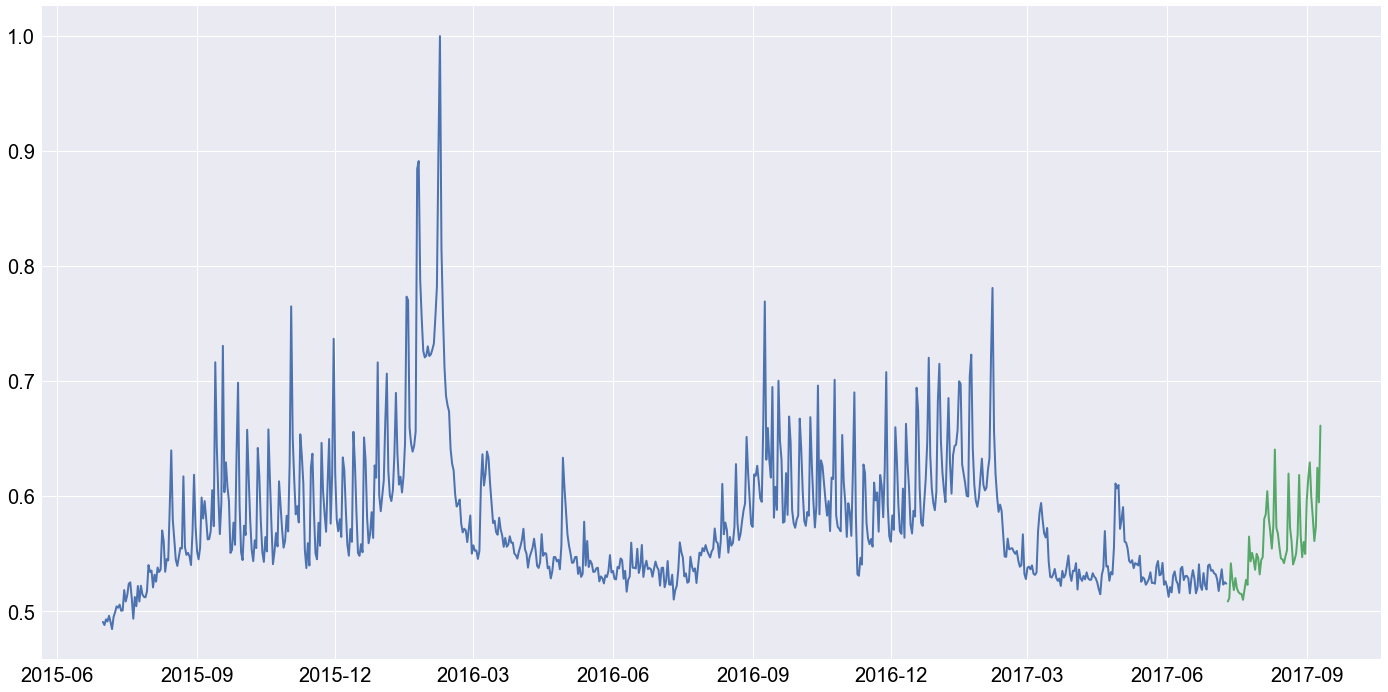

In [4]:
ts_example = ts_data[0]
plt.plot(ts_example["history"]["ds"], ts_example["history"]["y_scaled"])
plt.plot(ts_example["future"]["ds"], ts_example["future"]["y_scaled"])
ts_example["history"].head()

## Round 0:  

## Model: FB prophet regression model
We build a regression model similar to [Facebook Prophet](https://peerj.com/preprints/3190/); it combines trend, seasonality and holiday components with non-linear smoothers applied to regressors $t \in \mathbb{Z}^{T}$. 

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}  $$

- **Trend** <br/> $$g(t) = (k + \mathbf{a}(t)^{T} \boldsymbol{\delta})t + (m + \mathbf{a}(t)^{T} \boldsymbol{\gamma})$$
    - $k$ is the growth rate (slope)
    - $m$ is the offset (intercept)
    - $S$ changepoints are explicitly defined to allow trend changes at times $s_{j \in {1,2,...,S}}$
        - $\mathbf{a}(t) \in \{0,1\}^{S}$ are changepoint indicators
        - $\delta_{j} \sim Laplace(0,\tau)$ is the change of rate at time $s_{j}$
        - $\gamma_{j}$ is set to $-s_{j}\delta_{j}$ to make the function continuous</br>


- **Seasonality** <br/>
We construct Fourier series to approximate periodic seaonality.
$$s(t) = \sum_{n=1}^{N}(a_{n}cos(\frac{2\pi nt}{P}) + b_{n}sin(\frac{2\pi nt}{P} )) = X(t)  \boldsymbol{\beta}$$
    - $\boldsymbol{\beta} = [a_{1}, b_{1} , ... , a_{N}, b_{N}]^{T}$ and $\boldsymbol{\beta} \sim Normal(0,\sigma^{2})$
    - yearly -> (P = 365.25, N = 10)
    - weekly -> (P = 7, N = 3)
    

- **Holiday/Events** <br/>
Assuming holidays are independnet, we assign each holiday with a parameter $\kappa_{i}$
$$h(t) = Z(t) \boldsymbol{\kappa}$$
    - $Z(t) = [\boldsymbol{1}(t\in D_{1}) , ... , \boldsymbol{1}(t\in D_{L})]$
    - $\boldsymbol{\kappa} \sim Normal(0, \nu^2)$

Before modeling, we transform the raw data and extract features into proper format. The input data includes

- X
    - **t: ** time index
    - **X: ** seasonality vector after fourier transformation
    - **A: ** changepoint vector given time and number of change points
    - **sigmas: ** fixed scale on seasonality priors
- y
    - **y_scaled: ** `maxdiff(log(views))`

In [5]:
N_TS = len(ts_data)
S = len(train_data["t_change"])
K = train_data["X"].shape[1]

t = tf.placeholder(tf.float32, shape=None, name="t")              # time index
A = tf.placeholder(tf.float32, shape=(None, S), name="A")         # changepoint indicators
t_change = tf.placeholder(tf.float32, shape=(S), name="t_change") # changepoints_t
X = tf.placeholder(tf.float32, shape=(None, K), name="X")         # season vectors
sigmas = tf.placeholder(tf.float32, shape=(K,), name="sigmas")    # scale on seasonality prior
tau = tf.placeholder(tf.float32, shape=(), name="tau")

k = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial slope
m = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial intercept

sigma_obs = Normal(loc=tf.zeros(1), scale=0.5*tf.ones(1))   # noise
delta = Laplace(loc=tf.zeros(S), scale=tau*tf.ones(S))    # changepoint rate adjustment
gamma = tf.multiply(-t_change, delta)
beta = Normal(loc=tf.zeros(K), scale=sigmas*tf.ones(K))      # seasonal
trend_loc = (k + ed.dot(A, delta)) * t + \
            (m + ed.dot(A, gamma))
seas_loc = ed.dot(X, beta)
y = Normal(loc = trend_loc + seas_loc, scale = sigma_obs)

### 1.Inference: HMC
Given training data, the goal is to infer $k,m,\boldsymbol{\delta},\tau,\boldsymbol{\beta}$ and $\sigma$, where $k$ and $m$ are trend model parameters, $\boldsymbol{\delta}$ are latent variables for rate adjustment, $\boldsymbol{\beta}$ are smoothers for seasonality, $\tau$ and $\sigma$ are variance component parameters.

In this analysis, we use Monte Carlo with `ed.HMC` to infer the latent variables. All training data are passed in for inference and we tune step_size $= 0.0005$, n_steps $= 2$ with 5000 iterations

In [6]:
ITR = 5000
kinit, minit = init_km(ts_example["history"])
print("[+] Initial slope / intercept: %f, %f" % (kinit, minit))
qk = Empirical(params=tf.Variable(kinit * tf.ones([ITR, 1])))
qm = Empirical(params=tf.Variable(minit * tf.ones([ITR, 1])))
qsigma_obs = Empirical(params=tf.Variable(tf.ones([ITR, 1])))
qbeta = Empirical(params=tf.Variable(tf.zeros([ITR, K])))
qdelta = Empirical(params=tf.Variable(tf.zeros([ITR, S])))

[+] Initial slope / intercept: 0.033256, 0.490773


In [7]:
posts_dict = {
    k: qk, m: qm, sigma_obs: qsigma_obs,
    beta: qbeta, delta: qdelta}

data_dict = {
    y: ts_data[0]["history"]["y_scaled"].as_matrix(),
    t: train_data["t"],
    X: train_data["X"],
    sigmas: train_data["sigmas"],
    A: train_data["A"],
    t_change: train_data["t_change"],
    tau: 0.05,
}

inference = ed.HMC(posts_dict, data=data_dict)
STEP_SIZE = 5e-4
N_STEPS = 2
inference.run(step_size=STEP_SIZE, n_steps=N_STEPS)

5000/5000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 0.955


### 1.Prediction

Since [`HMC()`](https://github.com/blei-lab/edward/blob/e8e94174c4b8f4ef7fedde90e47c0a61de75ade4/edward/inferences/monte_carlo.py) in `Edward` has no burn-in implementation, we write our own posterior sampling method with manual burn-in.

In [8]:
nburn = int(ITR / 2)
stride = 5
sess = ed.get_session()
post_params = {
    "k": qk.params.eval()[nburn:ITR:stride],
    "m": qm.params.eval()[nburn:ITR:stride],
    "beta": qbeta.params.eval()[nburn:ITR:stride],
    "delta": qdelta.params.eval()[nburn:ITR:stride]
}

In [9]:
from prediction import *

pred_example = make_future_dataframe(ts_example["history"], ts_example["future"].shape[0])
pred_example = predict_fixed(pred_example, post_params, test_data)
pred_example_interval = predict_uncertainty(pred_example, post_params, test_data)
pred_example.head()

,ds,t,trend,seasonal,seasonal_lower,seasonal_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,y
0,2017-07-11,1.001351,0.580410,-0.056131,-0.063876,-0.048385,-0.002971,-0.006525,0.001159,-0.053160,-0.059956,-0.045995,0.524279
1,2017-07-12,1.002703,0.580496,-0.068783,-0.077001,-0.060588,-0.015302,-0.019159,-0.011285,-0.053481,-0.060387,-0.046511,0.511713
2,2017-07-13,1.004054,0.580582,-0.069114,-0.077026,-0.061193,-0.015432,-0.019273,-0.011581,-0.053681,-0.060572,-0.046656,0.511468
3,2017-07-14,1.005405,0.580668,-0.056230,-0.064145,-0.047931,-0.002497,-0.006149,0.001220,-0.053733,-0.060747,-0.046590,0.524438
4,2017-07-15,1.006757,0.580754,-0.063163,-0.072194,-0.054943,-0.009550,-0.014057,-0.005421,-0.053613,-0.060649,-0.046474,0.517591


,trend_lower,trend_upper,y_lower,y_upper
0,0.575307,0.585395,0.519176,0.529264
1,0.575366,0.585501,0.506583,0.516719
2,0.575414,0.585607,0.506301,0.516494
3,0.575475,0.585713,0.519245,0.529483
4,0.575543,0.585820,0.512380,0.522657


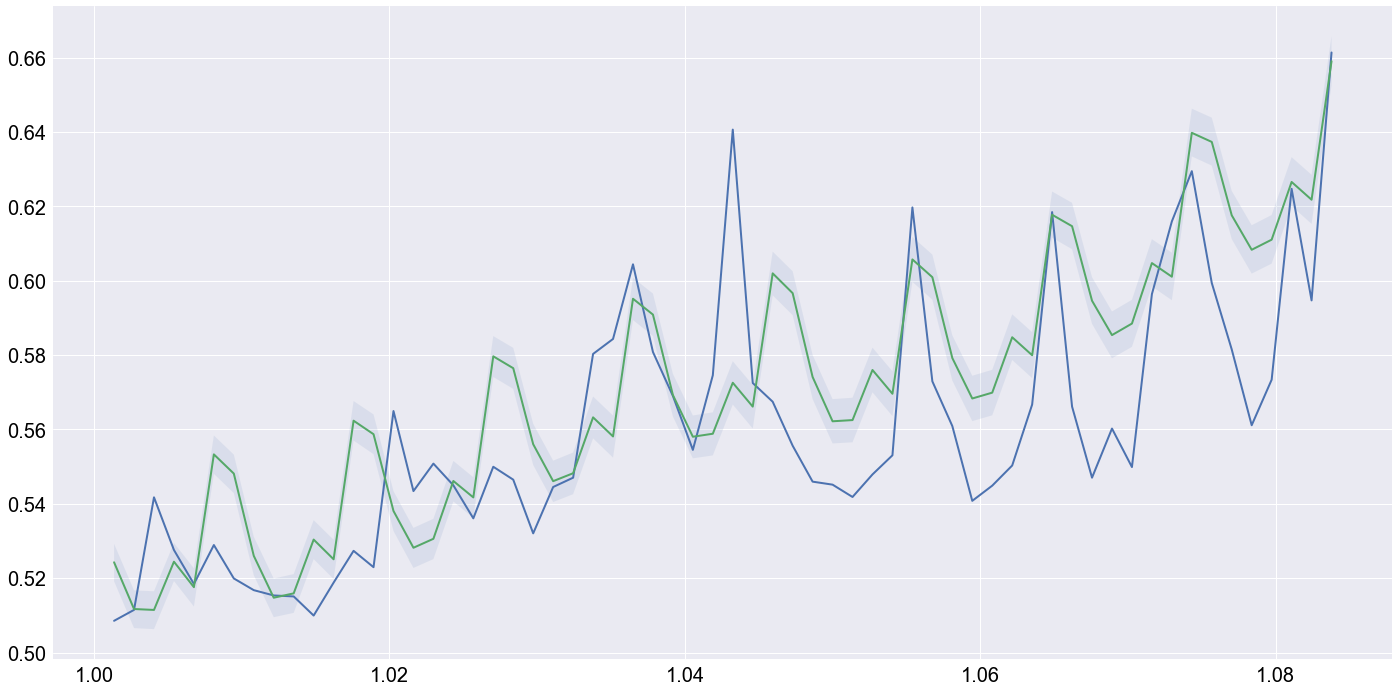

In [10]:
plt.plot(ts_example["future"]["t"], ts_example["future"]["y_scaled"])
plt.plot(pred_example["t"], pred_example["y"])
plt.fill_between(pred_example["t"], pred_example_interval["y_lower"], pred_example_interval["y_upper"], alpha=0.1)
pred_example_interval.head()

### 1.Criticism
- Pointwise evaluation

We use three metrics `MAPE`, `MSE` and `SMAPE` to help us compare the model and tune model parameters. `MAPE` penalizes more on negative errors and `SMAPE` could be unable when error is close zero. 


In [11]:
y_true = ts_example["future"]["y_scaled"].as_matrix()
metrics_example  = evaluate(y_true, pred_example["y"], prefix="example")
m_pd = pd.DataFrame.from_dict([metrics_example])
m_pd.loc['mean'] = m_pd.mean()
print(m_pd)

      example-MAPE  example-MSE  example-SMAPE
0         3.612184     0.000633       3.554302
mean      3.612184     0.000633       3.554302


In [12]:
# Training 
pred_train_example = pd.DataFrame({"ds": ts_example["history"]["ds"].copy(),
                                  "t": ts_example["history"]["t"].copy()})
pred_train_example.reset_index(inplace=True, drop=True)
pred_train_example = predict_fixed(pred_train_example, post_params, train_data)

- Visualization

One major benifit of implementing this regression model is that we can decompose the prediction results into their subcomponents and take a close look at each. Plotting time series and their components are extremely helpful for use to evaluate our model.

For example, we plot one of the time series below. The model captures the trend and weekly seasonality quite well but it is unable to pick up many local peaks. 

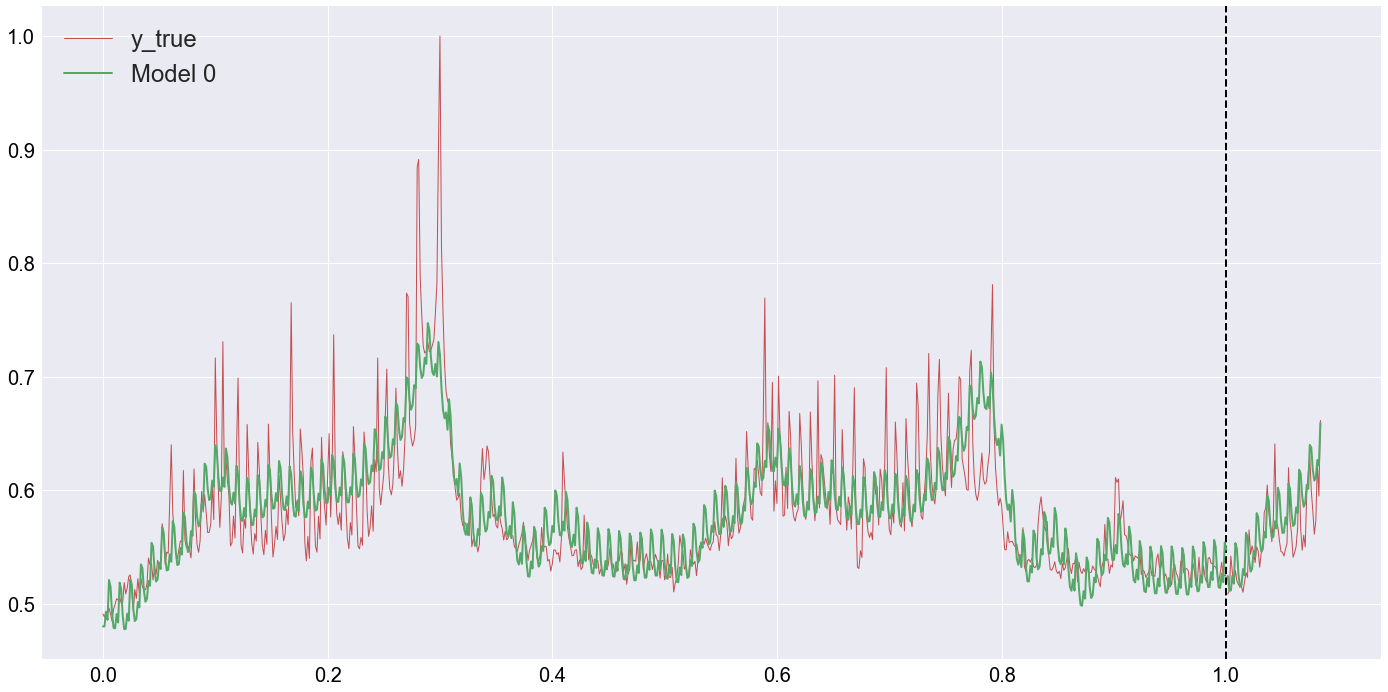

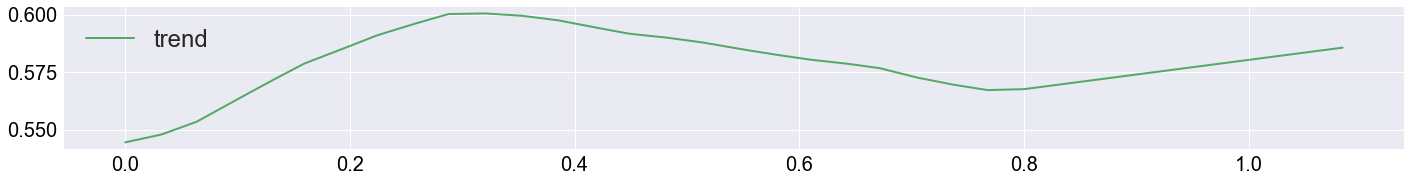

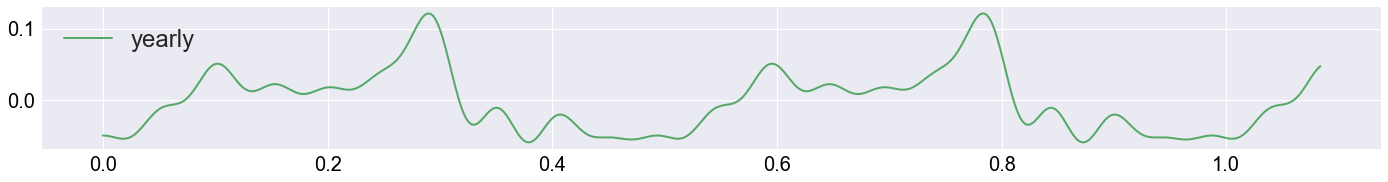

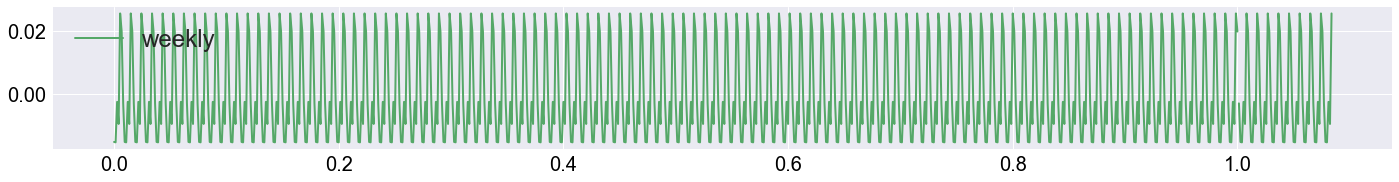

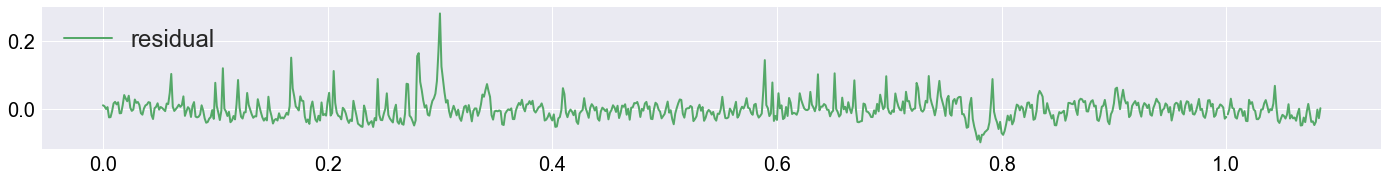

In [13]:
result_example = {"predictions": [pred_example], 
                  "metrics": [metrics_example]}
result_train_example = {"predictions": [pred_train_example]}
visualize_results([result_example], [result_train_example], ts_data, ts_idx=0)

We run a sanity check by ploting the precentage residual for prediction period. The residuals are normally distributed with mean at 0 and it ensures our model assumption.

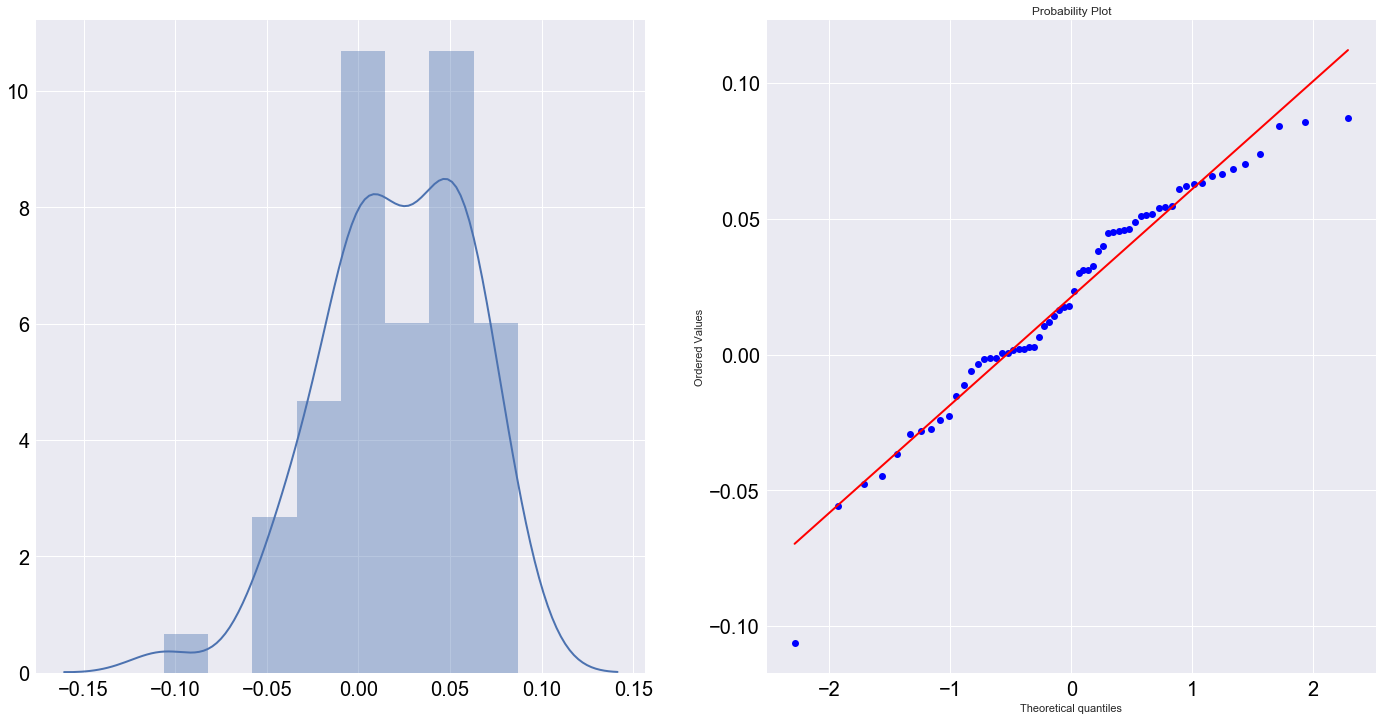

In [14]:
# Percentage Residual Check 
import scipy.stats as stats

plt.subplot(121)
resids = (pred_example["y"].as_matrix() - ts_example["future"]["y_scaled"].as_matrix()) / ts_example["future"]["y_scaled"].as_matrix()
sns.distplot(resids)
plt.subplot(122)
stats.probplot(resids, dist="norm", plot=plt)
plt.show()

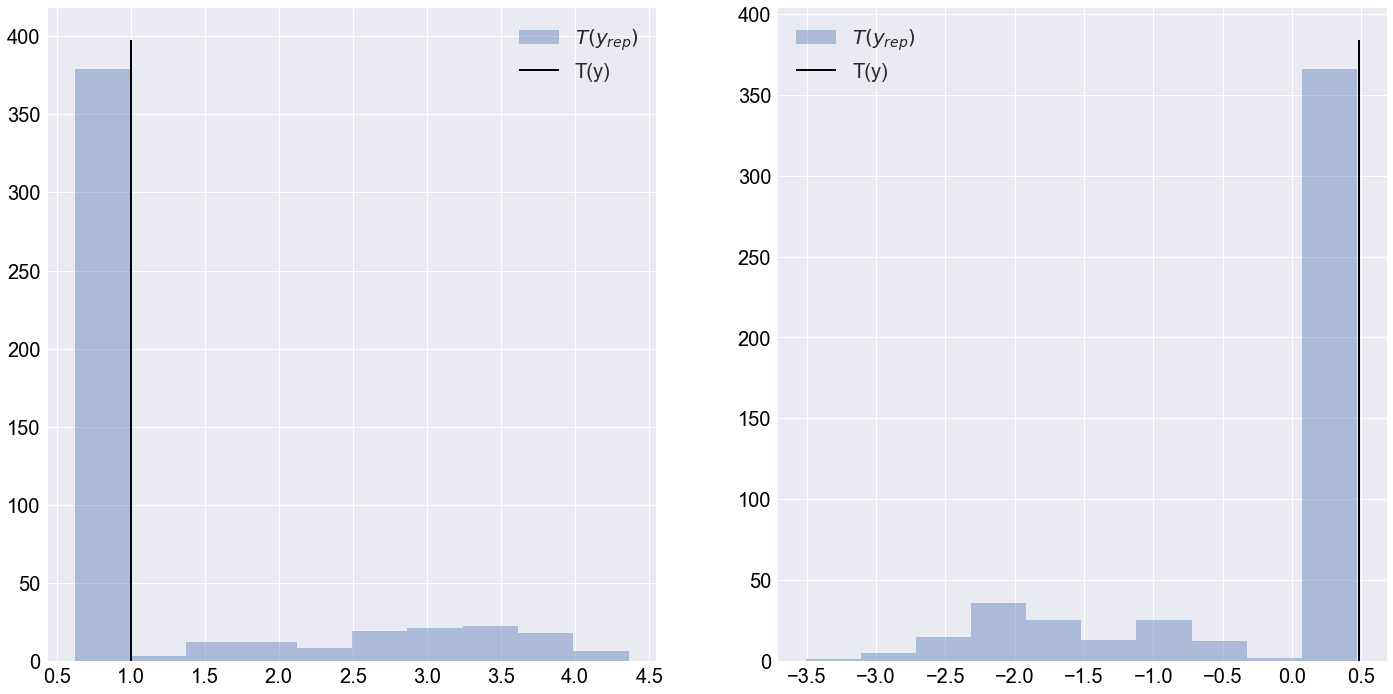

In [15]:
y_post = ed.copy(y, posts_dict)
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_max(tf.cast(xs[y_post], tf.float32)), 
       data={y_post:ts_data[0]["history"]["y_scaled"].as_matrix(), 
            t: train_data['t'],
            A: train_data['A'], 
            X: train_data['X'].as_matrix(), 
            sigmas: train_data['sigmas'], 
            t_change: train_data["t_change"]},n_samples=500)    
plt.subplot(121)
ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$max', bins=10)
plt.legend(fontsize=20)
plt.subplot(122)
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_min(tf.cast(xs[y_post], tf.float32)), 
       data={y_post:ts_data[0]["history"]["y_scaled"].as_matrix(), 
            t: train_data['t'],
            A: train_data['A'], 
            X: train_data['X'].as_matrix(), 
            sigmas: train_data['sigmas'], 
            t_change: train_data["t_change"]},n_samples=500)    
ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$min', bins=10)
plt.legend(fontsize=20)
plt.show()

## Round 1: 
___
### 2.Model
We modify the model by creating global latent variable inferring local variables. Preservating all local latent variables in Round 1, we modify the model by creating global latent variale inferring local trend and seasonality
- Global latent variables shared by all data

    - **`gk`** $\sim Normal(0, \sigma_{gk})$ while `k_i` $\sim Normal(gk, \sigma_{k_i})$ for $i = 1,...,10$
    - **`gbeta`** $\sim Normal(0, \sigma_{gbeta})$ while `beta_i` $\sim Normal(gbeta, \sigma_{beta_i})$ for $i = 1,...,10$
    
We compare three models train on 10 NFL wiki pageview data
- `Model1()`: no global latent variable
- `Model3()`: **`gbeta`** infers the local seasonality parameters 
- `Model4()`: **`gk`** infers the local trend slope

In [16]:
#%%capture
results = []
models_test = [Model1(), Model3(), Model4()]
print("Fitting %d Timeseries" % len(ts_data))
for model in models_test:
    p, m = pipeline(ts_data, model, train_data, test_data, 
                    ITR=5000, N_STEPS=2, STEP_SIZE=5e-4)
    results.append({"predictions": p, "metrics": m})

Fitting 10 Timeseries
[+] Building model
[+] Running inference
5000/5000 [100%] ██████████████████████████████ Elapsed: 67s | Acceptance Rate: 0.587
[+] Making prediction
[+] Building model
[+] Running inference
5000/5000 [100%] ██████████████████████████████ Elapsed: 74s | Acceptance Rate: 0.787
[+] Making prediction
[+] Building model
[+] Running inference
5000/5000 [100%] ██████████████████████████████ Elapsed: 88s | Acceptance Rate: 0.711
[+] Making prediction


In [17]:
total_metrics = []
for j, r in enumerate(results):
    m_pd = pd.DataFrame.from_dict(r["metrics"])
    m_pd.loc['mean'] = m_pd.mean()
    total_metrics.append(m_pd)
pd.concat(total_metrics, axis=1)

,model1-MAPE,model1-MSE,model1-SMAPE,model3-MAPE,model3-MSE,model3-SMAPE,model4-MAPE,model4-MSE,model4-SMAPE
0,3.387806,0.000553,3.383256,3.571079,0.000723,3.673537,3.533526,0.000713,3.634297
1,5.116845,0.001635,4.975179,5.216001,0.001647,5.059343,4.433259,0.001310,4.320388
2,6.839928,0.002115,7.182721,4.622114,0.001138,4.757186,4.609524,0.001061,4.695918
3,4.156450,0.001376,4.102259,4.216710,0.001500,4.192338,3.994424,0.001414,4.013432
4,4.787992,0.001819,4.751508,8.122059,0.004771,8.617298,6.486333,0.002920,6.702587
5,3.509429,0.000956,3.503438,3.174826,0.000920,3.257507,3.298267,0.000968,3.385439
6,5.069978,0.001283,4.920467,4.907926,0.001162,4.783815,5.227197,0.001281,5.084892
7,5.048415,0.001594,4.877200,3.279332,0.000702,3.218096,4.394100,0.001193,4.265402
8,9.596088,0.002926,9.084949,5.474949,0.001045,5.293842,5.133907,0.000934,4.973543
9,4.306163,0.001185,4.290891,3.837771,0.001010,3.815492,4.909114,0.001411,4.799740


We plot the percentage residual distribution for each data and compare `Model()`, `Models3()` and `Model4()` from left to right. As shown, the spreads become narrower towards the center and most of residuals are centered at 0. 

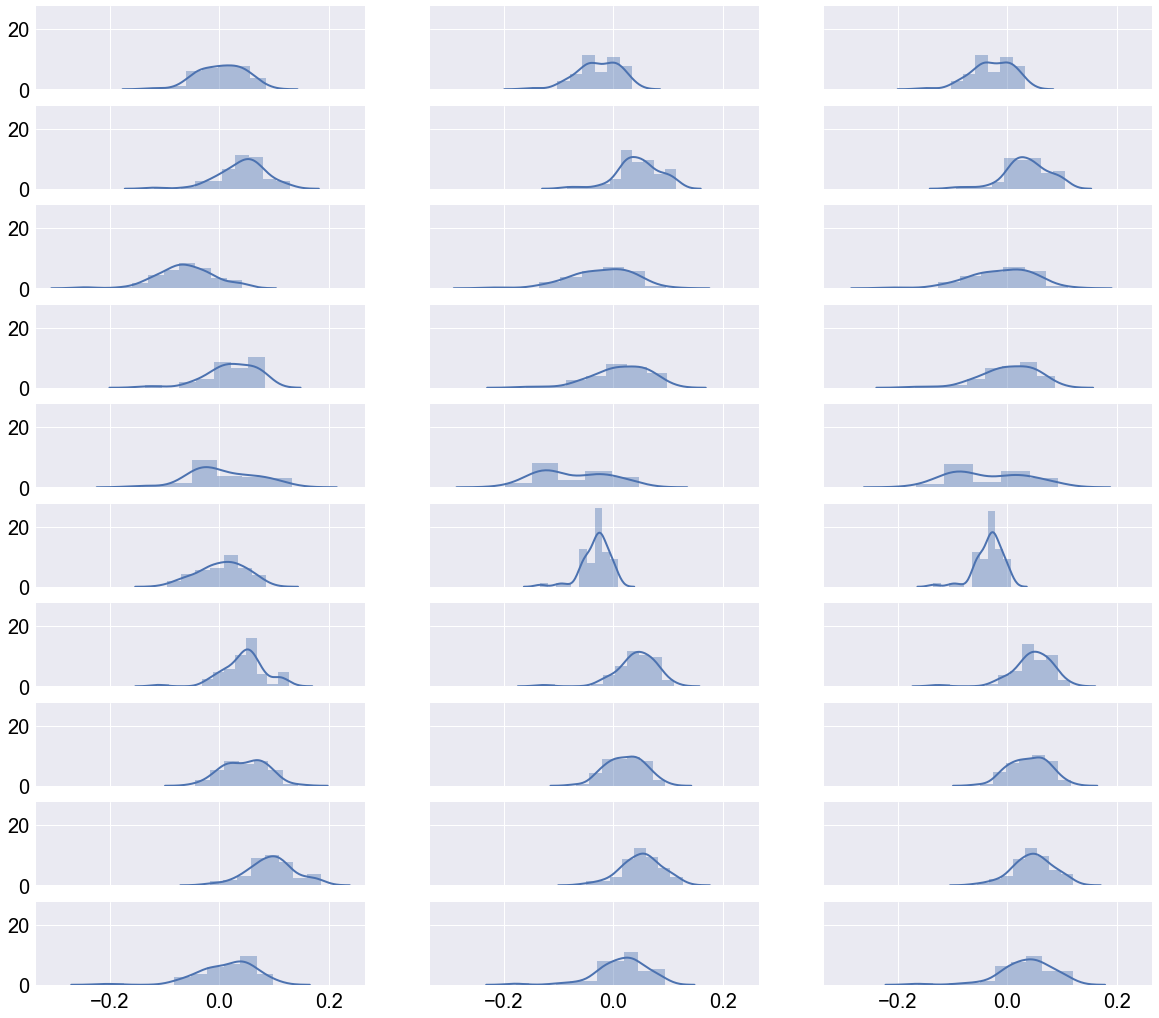

In [18]:
# residual
fig, axes = plt.subplots(len(ts_data), len(results), figsize=(20,18),
                         sharex=True, sharey=True)      
for j, r in enumerate(results):
    for i, ts in enumerate(ts_data):
        resids = (r["predictions"][i]["y"].as_matrix() - ts["future"]["y_scaled"].as_matrix()) \
                 / ts["future"]["y_scaled"].as_matrix()
        sns.distplot(resids, ax = axes[i, j])
plt.show()

In [19]:
# Fit Training 
results_train = []
for model in models_test:
    predictions = []
    metrics = []
    for i, ts in enumerate(ts_data):
        df = pd.DataFrame({"ds": ts["history"]["ds"].copy(),
                           "t": ts["history"]["t"].copy()})
        df.reset_index(inplace=True, drop=True)
        df = predict_fixed(df, model.post_params[i], train_data)
        predictions.append(df)
        y_true = ts["history"]["y_scaled"].as_matrix()
        metrics.append(evaluate(y_true, df["y"]))
            
    results_train.append({
        "predictions": predictions, 
        "metrics": metrics,
    })

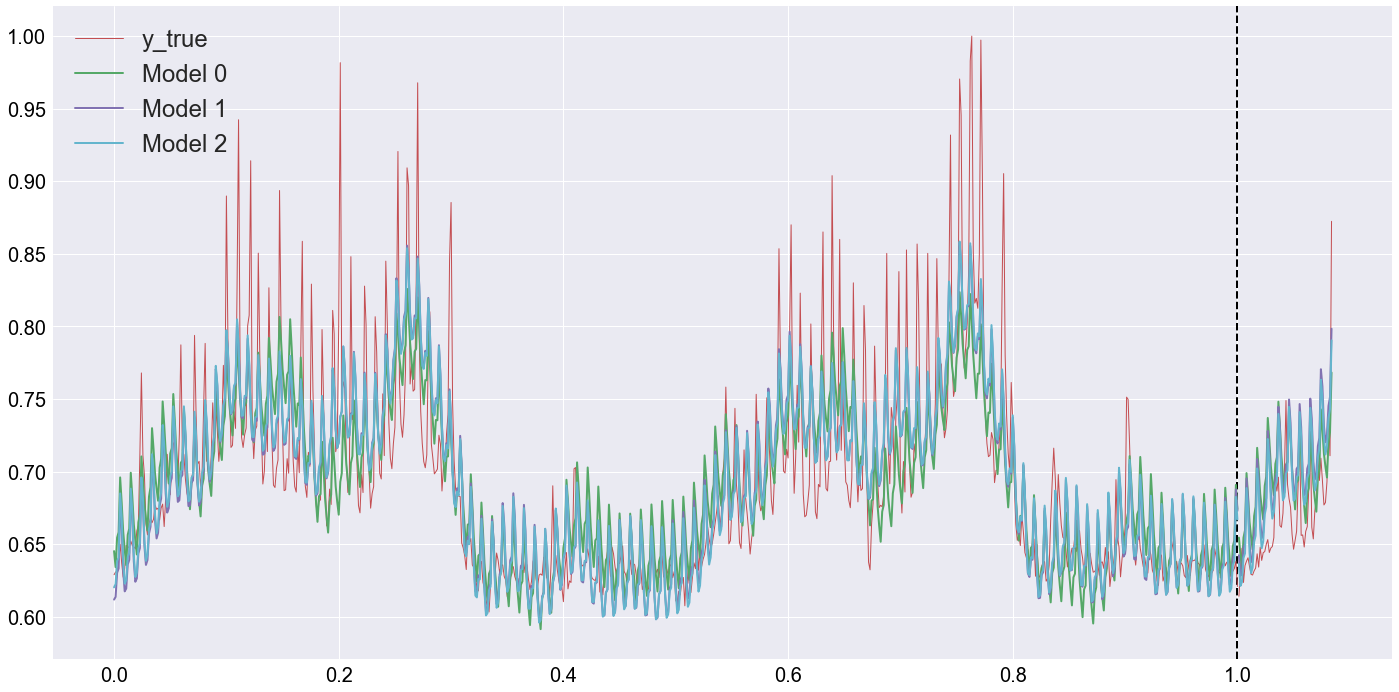

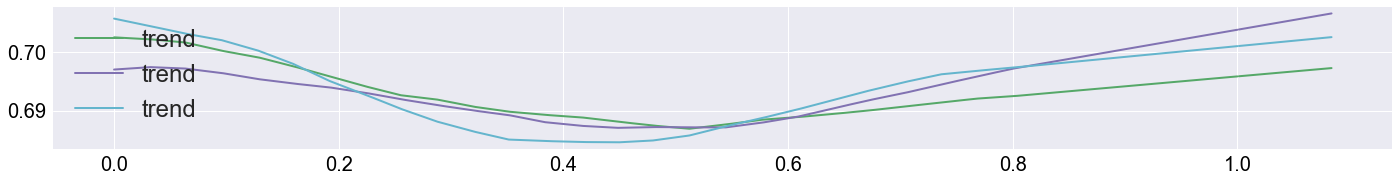

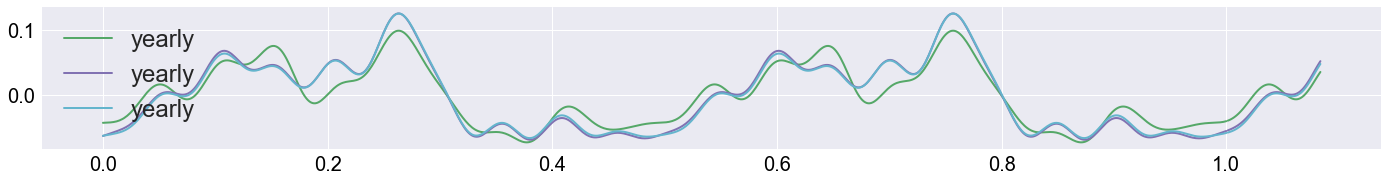

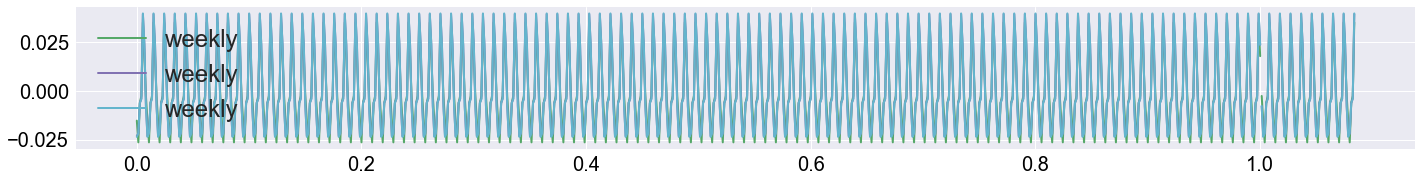

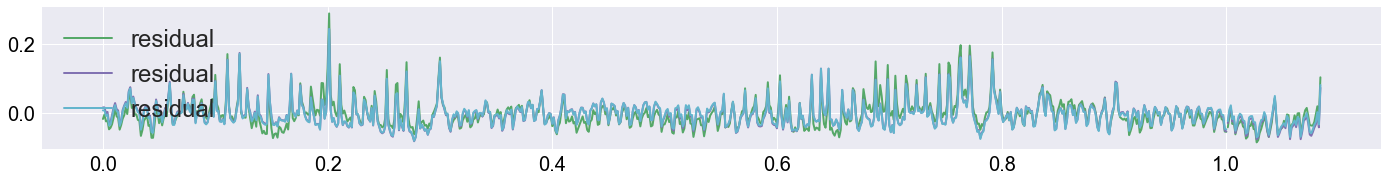

In [20]:
def visualize_results(results, results_train, ts_data, ts_idx=0):
    ts = ts_data[ts_idx]
    cs = ['C1', 'C3', 'C5']
    
    # train and test split
    plt.axvline(x=1., color='k',linestyle='--')

    # True data
    plt.plot(ts["history"]["t"], ts["history"]["y_scaled"].as_matrix(),
             lw=1, color='C2',label='y_true')
    plt.plot(ts["future"]["t"], ts["future"]["y_scaled"].as_matrix(),
             lw=1, color='C2',label='_nolegend_')

    for j, r in enumerate(results):
        df = r["predictions"][ts_idx]
        plt.plot(ts["future"]["t"], df["y"].as_matrix(),
                 label="Model %d" % j, color=cs[j])
        if results_train is not None:
            df_train = results_train[j]["predictions"][ts_idx]
            plt.plot(ts["history"]["t"], df_train["y"], color=cs[j],label='_nolegend_')
    plt.legend(loc=2, prop={'size': 24})
    #plt.legend(handles=[y_true_train,y_true_test])
    plt.show()

    plt.subplot(411)
    plot_component(results, results_train, "trend", ts_data, ts_idx, cs)
    plt.subplot(412)
    plot_component(results, results_train, "yearly", ts_data, ts_idx, cs)
    plt.subplot(413)
    plot_component(results, results_train, "weekly", ts_data, ts_idx, cs)
    plt.subplot(414)

    # Residual
    for j, r in enumerate(results):
        df = r["predictions"][ts_idx]
        plt.plot(ts["future"]["t"],
                 ts["future"]["y_scaled"].as_matrix() - df["y"].as_matrix(),
                 color=cs[j], label='residual')
        if results_train is not None:
            df_train = results_train[j]["predictions"][ts_idx]
            plt.plot(ts["history"]["t"],
                     ts["history"]["y_scaled"].as_matrix() -
                     df_train["y"].as_matrix(), color=cs[j])
    plt.legend(loc=2, prop={'size': 24})
    plt.show()

visualize_results(results, results_train, ts_data, ts_idx=1)

## 2. Criticism -- Model1 vs Model4 
hierarchical prior: k (linear growth)

model1
TS 0: 0.089598, 0.014096
TS 1: -0.010394, 0.019668
TS 2: 0.036821, 0.027742
TS 3: -0.033014, 0.017160
TS 4: 0.376924, 0.007762
TS 5: 0.043302, 0.006734
TS 6: 0.010071, 0.022125
TS 7: -0.007381, 0.037190
TS 8: 0.030891, 0.019552
TS 9: 0.066316, 0.012374


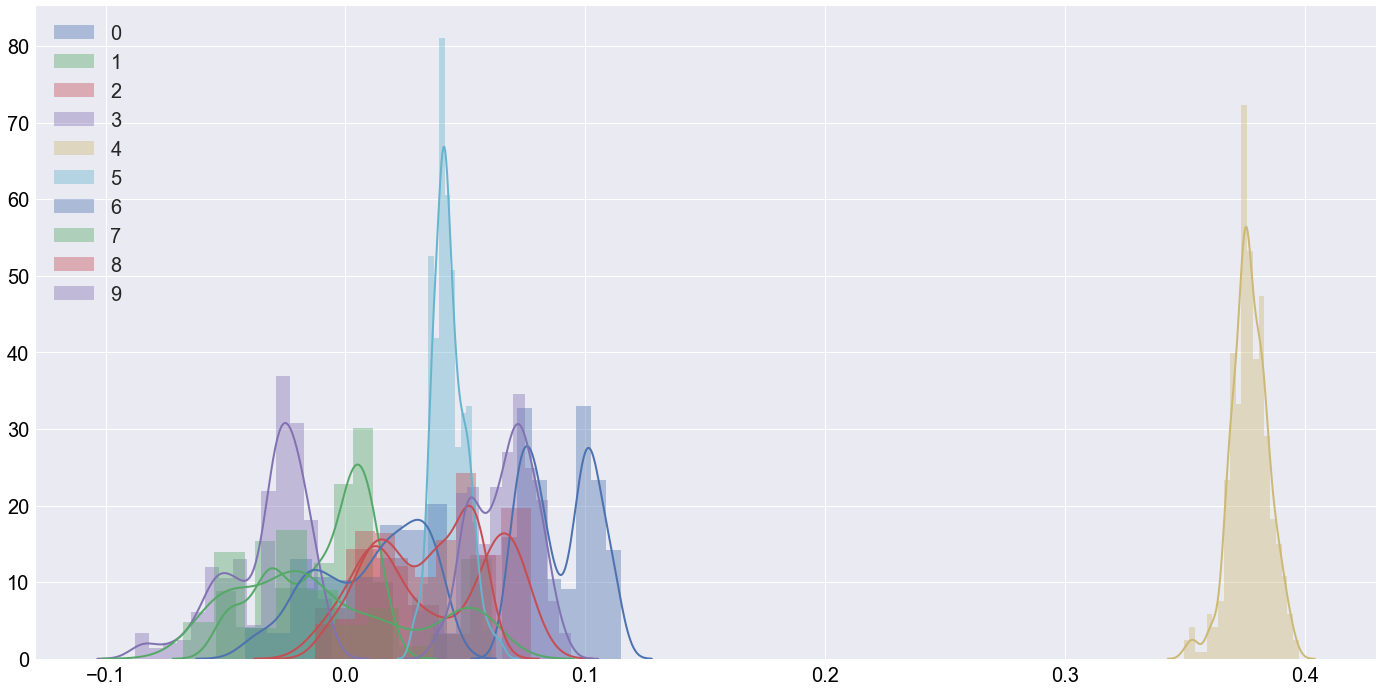

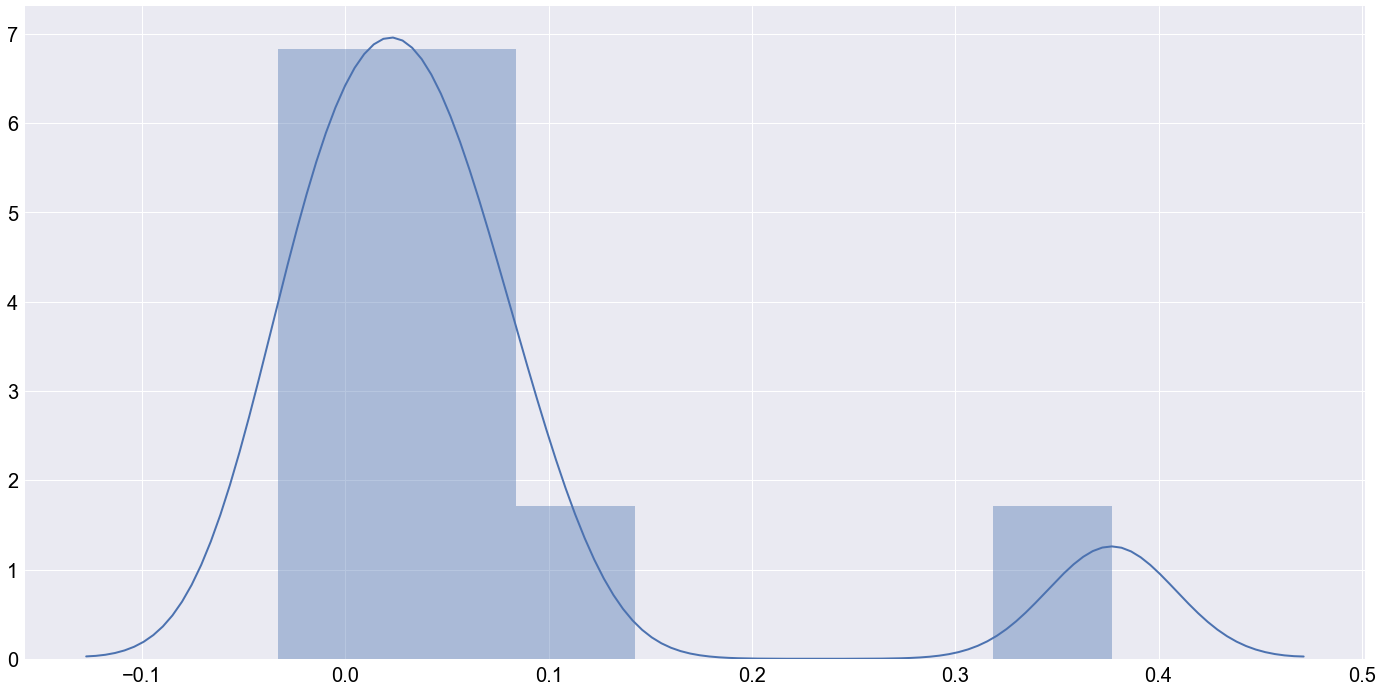

model4
TS 0: 0.100126, 0.011804
TS 1: -0.039764, 0.023748
TS 2: 0.070469, 0.012764
TS 3: -0.038001, 0.011712
TS 4: 0.424624, 0.014179
TS 5: -0.016474, 0.008420
TS 6: 0.067814, 0.025928
TS 7: 0.011033, 0.009330
TS 8: 0.024896, 0.010756
TS 9: 0.100171, 0.028475


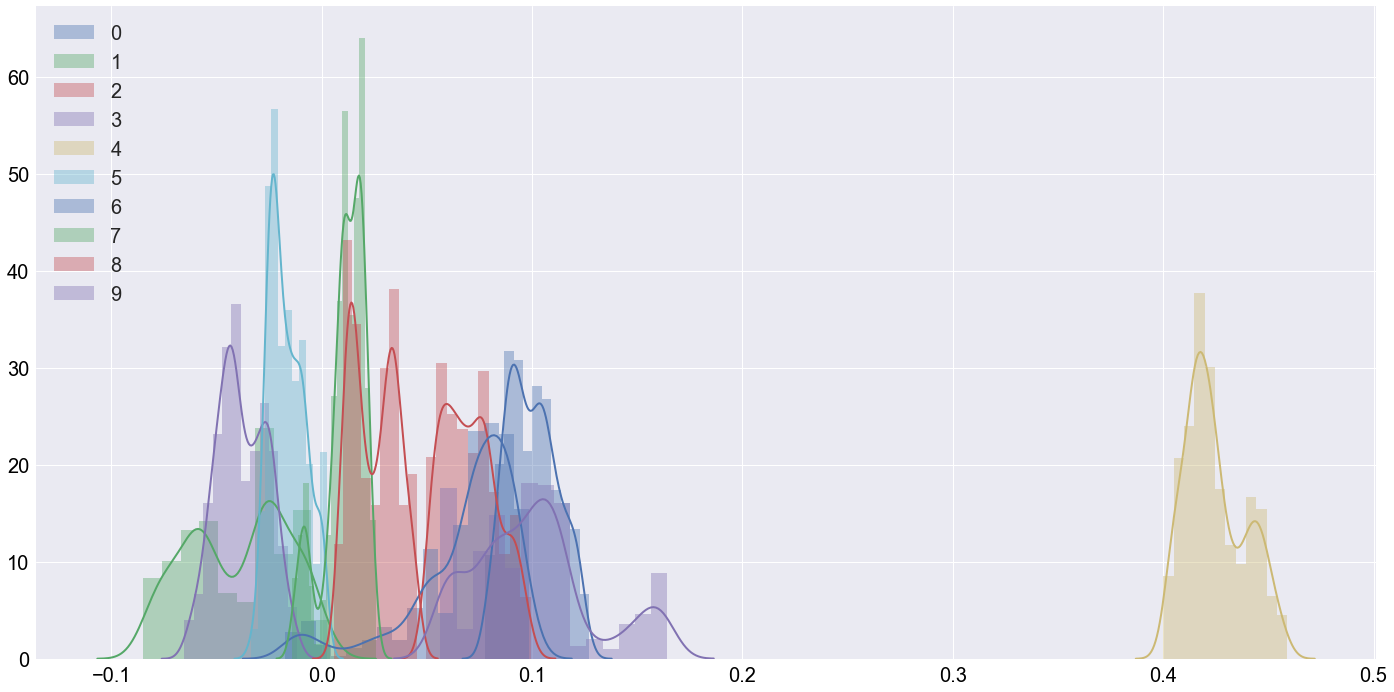

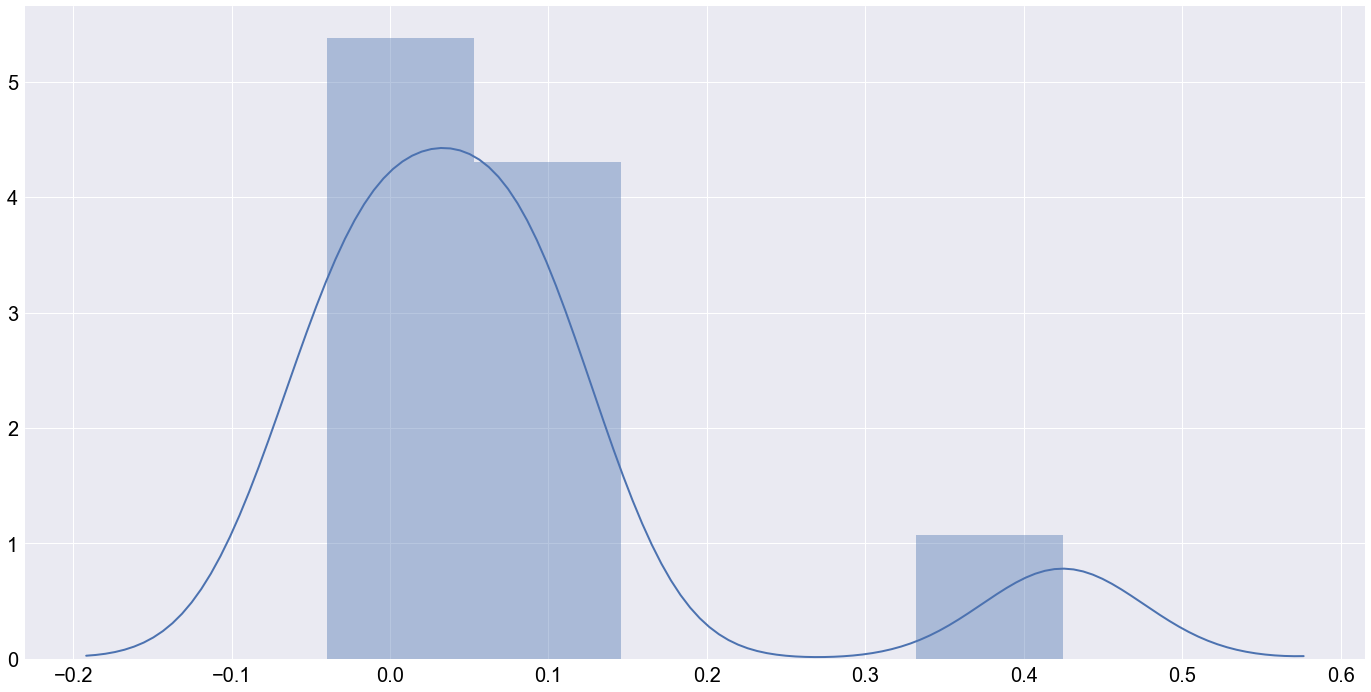

In [21]:
# Model 1
for m, model in enumerate([models_test[0], models_test[2]]):
    print(model.name)
    for i, ts in enumerate(ts_data):
        sns.distplot(model.post_params[i]["k"], label=str(i))
        print("TS %d: %f, %f" % (i, np.mean(model.post_params[i]["k"]), 
                                 np.std(model.post_params[i]["k"])))
    plt.legend(loc=2, fontsize=20)
    plt.show()
    sns.distplot([np.mean(model.post_params[i]["k"]) for i in range(len(ts_data))])
    plt.legend(loc=2, fontsize=20)
    plt.show()

## 2. Criticism -- Model1 vs Model3
hierarchical prior: beta (seasonality prior)

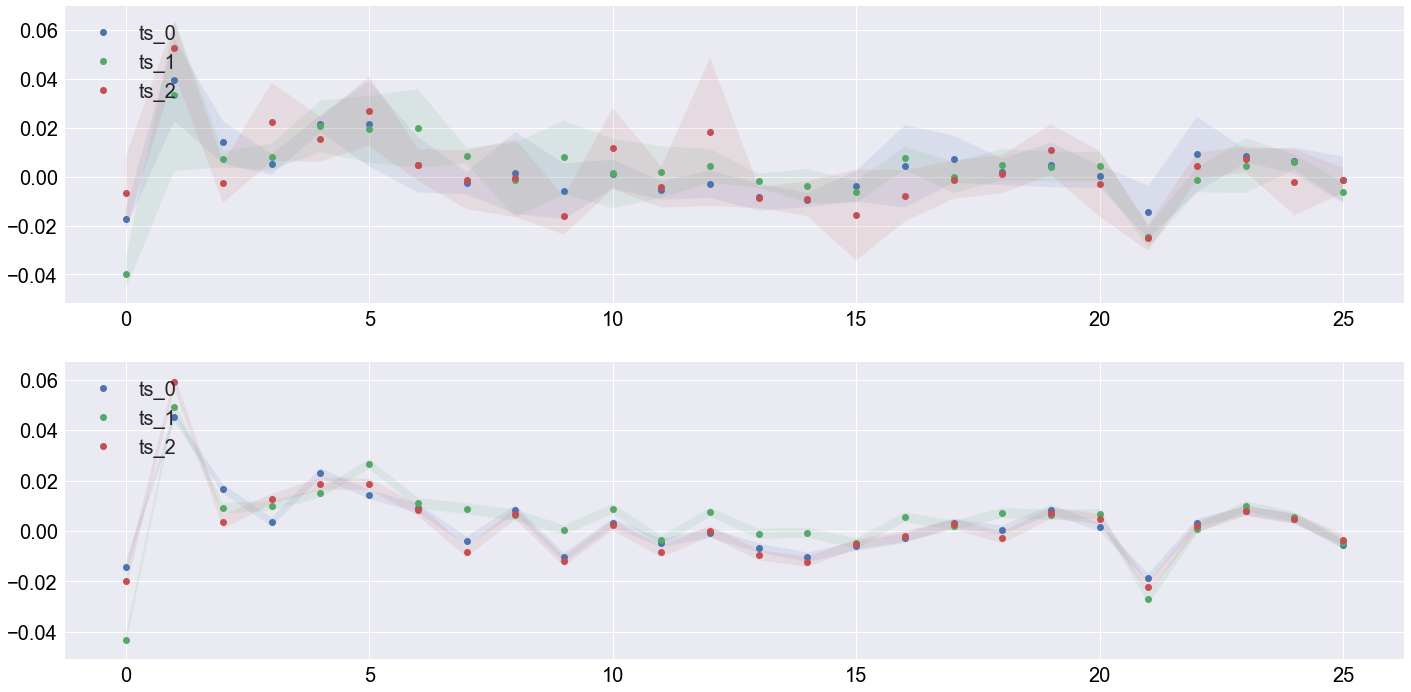

In [22]:
for m, model in enumerate([models_test[0], models_test[1]]):
    plt.subplot(2, 1, m+1)
    nbeta = len(model.post_params[i]["beta"][0])
    for i, ts in enumerate(ts_data[:3]):
        beta_mean = np.mean(model.post_params[i]["beta"], axis=0)
        beta_std = np.std(model.post_params[i]["beta"], axis=0)
        plt.plot(beta_mean, 'o', label='ts_'+str(i))
        plt.fill_between(range(nbeta), beta_mean -  beta_std,
                         beta_mean + beta_std, alpha=.1)        
    plt.legend(loc=2, fontsize=20)
plt.show()

## Conclusion and Lessions Learned


### Parameter Tuning
* Initial linear growth slope and intercept
  * global slope and intercept 
  * local slope and intercept (last P days)
  
* Holiday Features
  * US public holiday vs page-related events
  * domain knowledge
 
* Changepoint prior (tau) 
  * Fixed value vs latent variable 